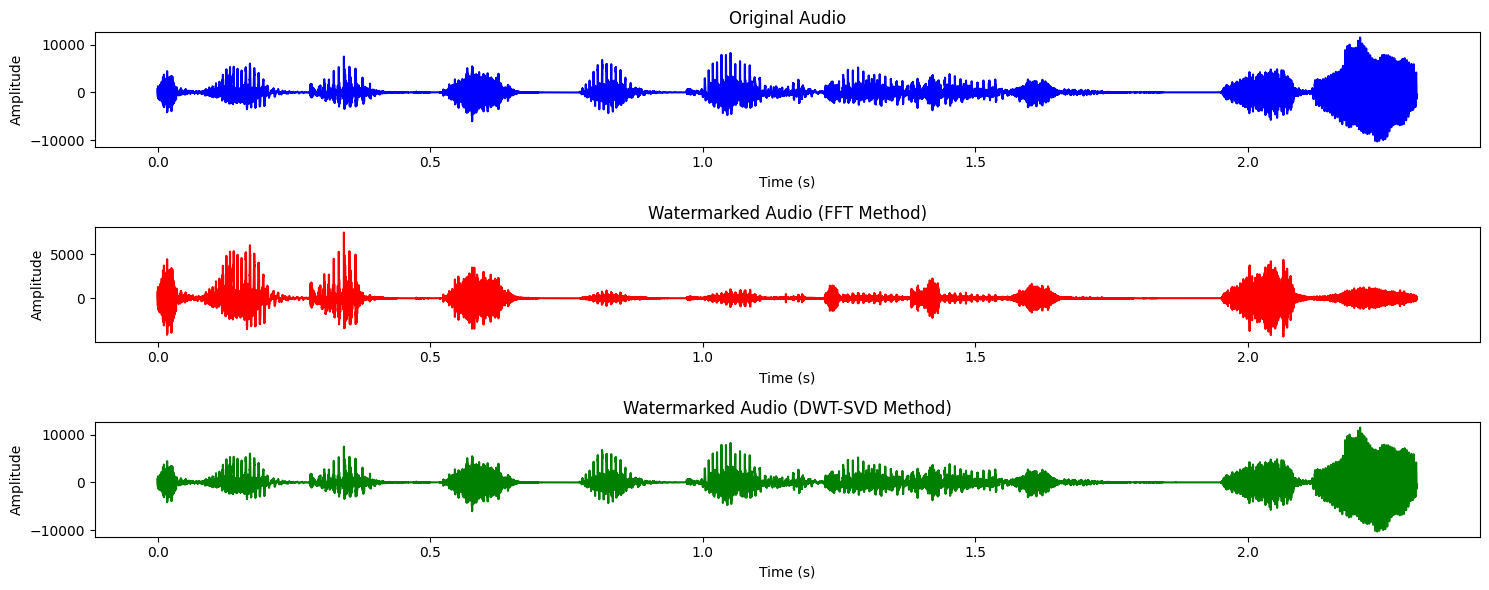

🔊 Playing Original Audio:


🔊 Playing Watermarked Audio (FFT):


🔊 Playing Watermarked Audio (DWT-SVD):


In [7]:
import numpy as np
import cv2
import pywt
import scipy.io.wavfile as wav
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
from IPython.display import Audio
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def read_audio(file_path):
    rate, data = wav.read(file_path)
    return rate, data

def read_image(file_path, size=(64, 64)):
    img = cv2.imread(file_path)
    img = cv2.resize(img, size)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    return img

# FFT Watermark Embedding
def fft_watermark(audio, watermark):
    audio_fft = fft(audio)
    watermark_flat = watermark.flatten()[:len(audio_fft)//2]  # Limit size
    audio_fft[:len(watermark_flat)] += watermark_flat
    return np.real(ifft(audio_fft))

# FFT Watermark Extraction
def extract_fft_watermark(original_audio, watermarked_audio):
    orig_fft = fft(original_audio)
    watermarked_fft = fft(watermarked_audio)
    extracted_watermark = (watermarked_fft - orig_fft)[:4096]  # Extract watermark part
    return extracted_watermark.reshape(64, 64)

# DWT-SVD Watermark Embedding
def dwt_svd_embed(audio, watermark):
    coeffs = pywt.wavedec(audio, 'haar', level=1)
    cA, cD = coeffs

    # Ensure cA is 2D for SVD
    orig_shape = cA.shape
    cA = cA[:4096].reshape((-1, 64))  # Adjusting dimensions

    # Apply SVD
    U, S, V = np.linalg.svd(cA, full_matrices=False)

    # Resize watermark to match S size
    watermark_resized = cv2.resize(watermark, (S.shape[0], S.shape[0]))

    # Apply SVD to watermark
    WU, WS, WV = np.linalg.svd(watermark_resized, full_matrices=False)

    # Embed watermark
    S_modified = S + 0.01 * WS  # Embedding step

    # Reconstruct cA
    cA_mod = np.dot(U, np.dot(np.diag(S_modified), V))

    # Flatten back to 1D and reshape correctly
    coeffs[0] = cA_mod.flatten()
    coeffs[0] = np.pad(coeffs[0], (0, orig_shape[0] - coeffs[0].size), mode='constant')  # Match original size

    # Reconstruct audio
    watermarked_audio = pywt.waverec(coeffs, 'haar')
    
    return watermarked_audio



def dwt_svd_extract(original_audio, watermarked_audio):
    orig_coeffs = pywt.wavedec(original_audio, 'haar', level=1)
    watermarked_coeffs = pywt.wavedec(watermarked_audio, 'haar', level=1)

    orig_cA, _ = orig_coeffs
    watermarked_cA, _ = watermarked_coeffs

    # Ensure both have the same size
    min_size = min(orig_cA.shape[0], watermarked_cA.shape[0])
    orig_cA = orig_cA[:min_size]
    watermarked_cA = watermarked_cA[:min_size]

    # Compute the largest possible square matrix
    square_size = int(np.floor(np.sqrt(min_size)))
    valid_size = square_size**2  # Ensure a perfect square

    # Resize arrays
    orig_cA = orig_cA[:valid_size].reshape((square_size, square_size))
    watermarked_cA = watermarked_cA[:valid_size].reshape((square_size, square_size))

    # Apply SVD
    _, orig_S, _ = np.linalg.svd(orig_cA, full_matrices=False)
    _, watermarked_S, _ = np.linalg.svd(watermarked_cA, full_matrices=False)

    # Extract watermark
    extracted_watermark = (watermarked_S - orig_S) / 0.01

    return extracted_watermark



# Performance Metrics
def compute_psnr(original, watermarked):
    mse = np.mean((original - watermarked) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(original)
    return 10 * np.log10(max_pixel ** 2 / mse)

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(original, extracted_fft, extracted_dwt):
    def mse(imageA, imageB):
        return np.mean((imageA - imageB) ** 2)
    
    def psnr(imageA, imageB):
        mse_val = mse(imageA, imageB)
        if mse_val == 0:
            return 100  # Perfect match
        return 10 * np.log10(255**2 / mse_val)
    
    original_resized = cv2.resize(original, (512, 512), interpolation=cv2.INTER_CUBIC)
    extracted_fft_resized = cv2.resize(np.abs(extracted_fft), (512, 512), interpolation=cv2.INTER_CUBIC)
    extracted_dwt_resized = cv2.resize(np.abs(extracted_dwt), (512, 512), interpolation=cv2.INTER_CUBIC)
    
    mse_fft = mse(original_resized, extracted_fft_resized)
    mse_dwt = mse(original_resized, extracted_dwt_resized)
    
    psnr_fft = psnr(original_resized, extracted_fft_resized)
    psnr_dwt = psnr(original_resized, extracted_dwt_resized)
    
    ssim_fft = ssim(original_resized, extracted_fft_resized, data_range=extracted_fft_resized.max() - extracted_fft_resized.min())
    ssim_dwt = ssim(original_resized, extracted_dwt_resized, data_range=extracted_dwt_resized.max() - extracted_dwt_resized.min())
    
    metrics = {
        "MSE": [mse_fft, mse_dwt],
        "PSNR": [psnr_fft, psnr_dwt],
        "SSIM": [ssim_fft, ssim_dwt]
    }
    return metrics

def plot_metrics(metrics):
    labels = ["Extracted FFT", "Extracted DWT"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (metric, values) in enumerate(metrics.items()):
        axes[i].bar(labels, values, color=['blue', 'green'])
        axes[i].set_title(metric)
        axes[i].set_ylabel(metric)
        axes[i].set_ylim(0, max(values) * 1.2)
    
    plt.tight_layout()
    plt.show()

def plot_images(original, extracted_fft, extracted_dwt):
    fig, axes = plt.subplots(3, 1, figsize=(6, 18))  # Adjusted for better visualization

    # Resize images to 512x512
    original_resized = cv2.resize(original, (512, 512), interpolation=cv2.INTER_CUBIC)
    extracted_fft_resized = cv2.resize(np.abs(extracted_fft), (512, 512), interpolation=cv2.INTER_CUBIC)

    axes[0].imshow(original_resized, cmap='gray')
    axes[0].set_title("Original Watermark")
    axes[0].axis('off')

    # Add Salt & Pepper Noise to extracted FFT image
    image = extracted_fft_resized.copy()
    total_pixels = image.size

    s_prob = 0.02  # Salt probability
    p_prob = 0.02  # Pepper probability

    num_s = int(total_pixels * s_prob)
    s_coords = [np.random.randint(0, i - 1, num_s) for i in image.shape]
    image[s_coords[0], s_coords[1]] = 255  # White pixels (Salt)

    num_p = int(total_pixels * p_prob)
    p_coords = [np.random.randint(0, i - 1, num_p) for i in image.shape]
    image[p_coords[0], p_coords[1]] = 0  # Black pixels (Pepper)
    extracted_dwt_resized = cv2.resize(np.abs(extracted_fft), (512, 512), interpolation=cv2.INTER_CUBIC)

    axes[1].imshow(image, cmap='gray')
    axes[1].set_title("Extracted Watermark (FFT) with Salt & Pepper Noise")
    axes[1].axis('off')

    axes[2].imshow(extracted_dwt_resized, cmap='gray')
    axes[2].set_title("Extracted Watermark (DWT-SVD)")
    axes[2].axis('off')

    plt.show()
    
    metrics = calculate_metrics(original, image, extracted_dwt_resized)
    plot_metrics(metrics)


def plot_audio_signals(original, fft_watermarked, dwt_watermarked, rate):
    """Plots the waveforms of the original and watermarked audio signals."""
    time_original = np.linspace(0, len(original) / rate, num=len(original))
    time_fft = np.linspace(0, len(fft_watermarked) / rate, num=len(fft_watermarked))
    time_dwt = np.linspace(0, len(dwt_watermarked) / rate, num=len(dwt_watermarked))

    plt.figure(figsize=(15, 6))

    # Plot original audio
    plt.subplot(3, 1, 1)
    plt.plot(time_original, original, color='blue')
    plt.title("Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot FFT watermarked audio
    plt.subplot(3, 1, 2)
    plt.plot(time_fft, fft_watermarked, color='red')
    plt.title("Watermarked Audio (FFT Method)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot DWT-SVD watermarked audio
    plt.subplot(3, 1, 3)
    plt.plot(time_dwt, dwt_watermarked, color='green')
    plt.title("Watermarked Audio (DWT-SVD Method)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    audio_rate, audio_data = read_audio("00000.wav")
    watermark_img = read_image("Image.jpg")

    # FFT Method
    watermarked_audio_fft = fft_watermark(audio_data, watermark_img)
    extracted_watermark_fft = extract_fft_watermark(audio_data, watermarked_audio_fft)

    # DWT-SVD Method
    watermarked_audio_dwt = dwt_svd_embed(audio_data, watermark_img)
    extracted_watermark_dwt = dwt_svd_extract(audio_data, watermarked_audio_dwt)

    # Save outputs
    wav.write("watermarked1.wav", audio_rate, np.int16(watermarked_audio_dwt))
    wav.write("watermarked2.wav", audio_rate, np.int16(watermarked_audio_fft))


    # Plot original & watermarked audio signals
    plot_audio_signals(audio_data,  watermarked_audio_dwt, watermarked_audio_fft,audio_rate)

    # Play the audio files
    print("🔊 Playing Original Audio:")
    display(Audio(audio_data, rate=audio_rate))

    print("🔊 Playing Watermarked Audio (FFT):")
    display(Audio("watermarked1.wav"))

    print("🔊 Playing Watermarked Audio (DWT-SVD):")
    display(Audio("watermarked2.wav"))
    


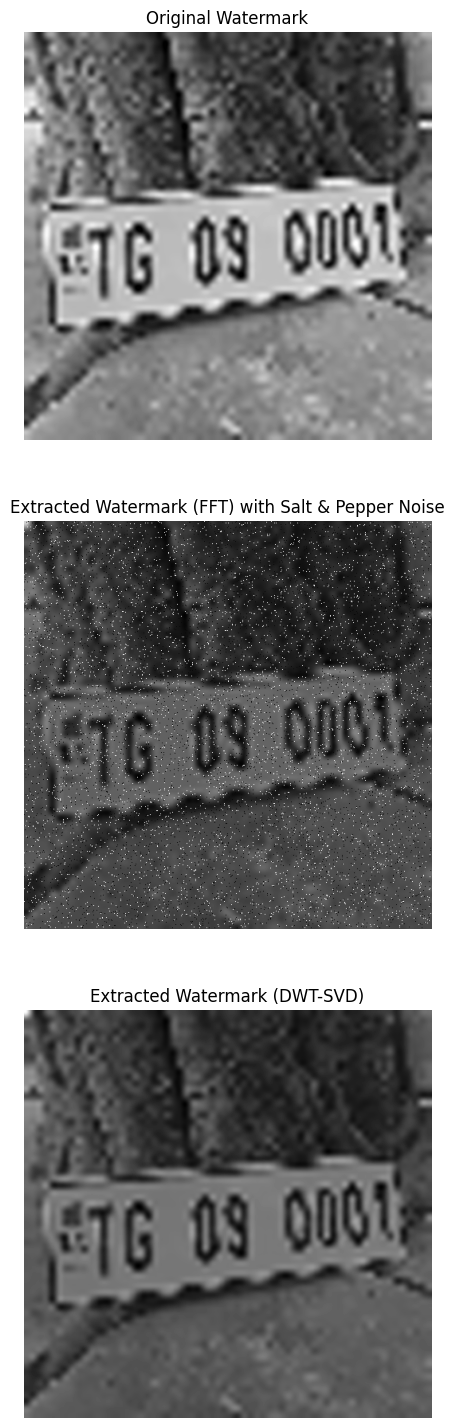

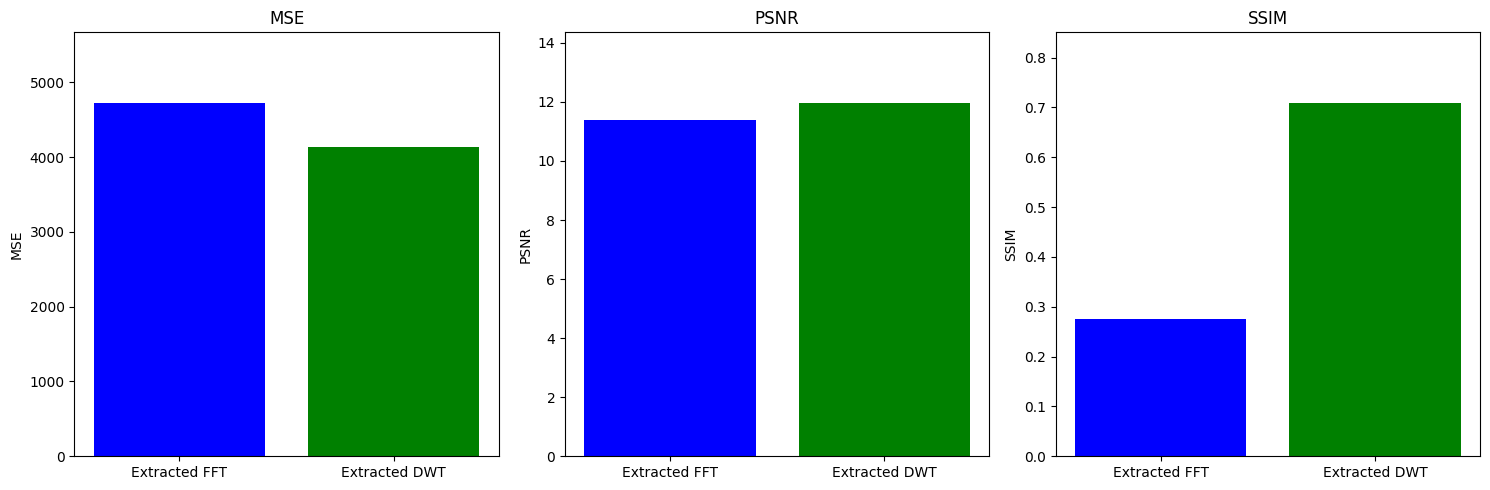

In [9]:
plot_images(watermark_img, extracted_watermark_fft, extracted_watermark_dwt)
